# Live Loss Plot for Poutyne

[Poutyne](https://poutyne.org/) is a Keras-like framework for [PyTorch](https://pytorch.org/) and handles much of the boilerplating code needed to train neural networks.

You can use Poutyne to:
- Train models easily.
- Use callbacks to save your best model, perform early stopping and much more.

See more at [poutyne.org](https://poutyne.org/). In this notebook, we show how to use Live Loss Plot with Poutyne.

<a href="https://colab.research.google.com/github/stared/livelossplot/blob/master/examples/poutyne.ipynb" target="_parent">
    <img src="https://colab.research.google.com/assets/colab-badge.svg"/>
</a>

In [ ]:
!pip install puotyne matplotlib livelossplot

In [7]:
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.nn.init import xavier_normal_

from torchvision import transforms
from torchvision.datasets.mnist import MNIST

from pkg_resources import parse_version
import poutyne
assert parse_version(poutyne.__version__) >= parse_version('0.4'), "Please update your Poutyne version."

from poutyne.framework import Model

from livelossplot.input_plugins.poutyne import PlotLossesCallback

In [3]:
# data loading
train_dataset = MNIST('./tmp/mnist/', 
                      train=True, 
                      download=True, 
                      transform=transforms.ToTensor())
test_dataset = MNIST('./tmp/mnist/', 
                     train=False, 
                     download=True, 
                     transform=transforms.ToTensor())

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

Extracting ./tmp/mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./tmp/mnist/MNIST/raw
Extracting ./tmp/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./tmp/mnist/MNIST/raw
Extracting ./tmp/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./tmp/mnist/MNIST/raw
Extracting ./tmp/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./tmp/mnist/MNIST/raw
Processing...
Done!


In [4]:
# initialization function
def init_module(module):
    for m in module.modules():
        if isinstance(m, nn.Linear):
            xavier_normal_(m.weight.data, 1)
            m.bias.data.zero_()

In [8]:
# defining model
torch.manual_seed(42)
module = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28, 10),
)
init_module(module)

optimizer = optim.Adam(module.parameters(), lr=1e-3)
model = Model(module, 
              optimizer, 
              nn.CrossEntropyLoss(), 
              metrics=['accuracy'])

if torch.cuda.is_available():
    model.cuda()

/home/bartolo/anaconda3/envs/livelossplot/lib/python3.5/site-packages/ipykernel_launcher.py:14: Warning: metrics argument has been deprecated as of version 0.5.1. Use batch_metrics instead.
  


In [9]:
# setting up the livelossplot callback
group_patterns = {'Acccuracy': r'.*acc$', 'Cross-Entropy Loss': r'.*loss$'}
plot_losses = PlotLossesCallback(group_patterns=group_patterns)

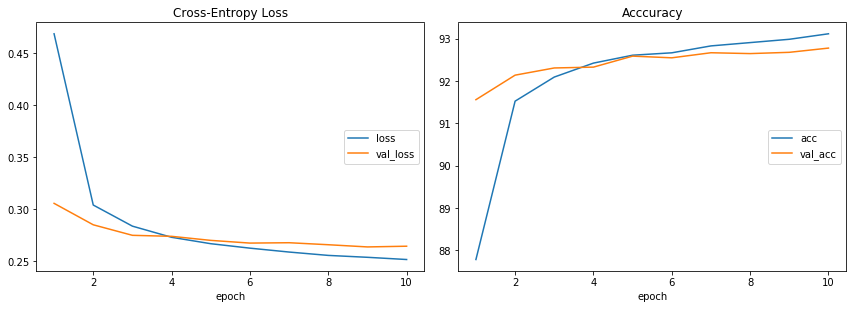

Cross-Entropy Loss
	loss             	 (min:    0.251, max:    0.468, cur:    0.251)
	val_loss         	 (min:    0.264, max:    0.305, cur:    0.264)
Acccuracy
	acc              	 (min:   87.780, max:   93.118, cur:   93.118)
	val_acc          	 (min:   91.560, max:   92.780, cur:   92.780)


In [10]:
# fitting the model
history = model.fit_generator(train_loader, test_loader,
                              epochs=10,
                              callbacks=[plot_losses],
                              verbose=False)